# TEXT CLASSIFICATION EXERCISE - Kaggle competition on Tweets sentiment analysis
Master in Artificial Intelligence<br>
Natural Langage Processing Class<br>
Frank Barreto<br>
20/11/2021<br>

### Import libraries and define useful functions

In [514]:
%reset

import tensorflow as tf
print(tf.__version__)

import nltk

import csv
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout, Bidirectional,\
SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras import layers, initializers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
#Stemmer.
from nltk.stem.snowball import SnowballStemmer
#Lemmatization.
from nltk import WordNetLemmatizer
tok = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
2.7.0


In [515]:
import matplotlib.pyplot as plt

# function to plot train and validation over epochs
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [516]:
# function to plot confussion matrix
def plot_confussion_matrix(labels, predictions, classes, figsize = 3):
    
    con_mat = tf.math.confusion_matrix(labels, predictions).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 3)

    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)

    figure = plt.figure(figsize=(figsize, figsize))
    sns.heatmap(con_mat_df
                , annot=True
                , xticklabels=classes
                , yticklabels=classes
                #, cmap=plt.cm.Blues
                )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlim(-0.0, len(classes))
    plt.ylim(len(classes), -0.0)
    plt.show()

### Read 10% of Kaggle data
downloaded from: https://www.kaggle.com/kazanova/sentiment140

In [517]:
n=10 # every 10th row = 10% of the rows. This way we get a diverse representation of the dataset.
df = pd.read_csv('training.1600000.processed.noemoticon.csv'
                 , encoding = 'latin-1'#'utf-8'
                 , delimiter = ','
                 , index_col = False
                 , header = 1
                 , usecols = [0, 1, 2, 3, 4, 5]
                 , names = ['target', 'ids', 'date', 'flag', 'user', 'text']
                 , skiprows=lambda i: i % n != 0
)
print(df.shape)
df.head(20)


(159998, 6)


target         ids                          date      flag  \
0        0  1467813985  Mon Apr 06 22:20:37 PDT 2009  NO_QUERY   
1        0  1467815923  Mon Apr 06 22:21:07 PDT 2009  NO_QUERY   
2        0  1467818020  Mon Apr 06 22:21:39 PDT 2009  NO_QUERY   
3        0  1467820863  Mon Apr 06 22:22:23 PDT 2009  NO_QUERY   
4        0  1467822687  Mon Apr 06 22:22:52 PDT 2009  NO_QUERY   
5        0  1467825411  Mon Apr 06 22:23:35 PDT 2009  NO_QUERY   
6        0  1467834053  Mon Apr 06 22:25:52 PDT 2009  NO_QUERY   
7        0  1467835345  Mon Apr 06 22:26:10 PDT 2009  NO_QUERY   
8        0  1467836873  Mon Apr 06 22:26:33 PDT 2009  NO_QUERY   
9        0  1467838189  Mon Apr 06 22:26:54 PDT 2009  NO_QUERY   
10       0  1467839737  Mon Apr 06 22:27:21 PDT 2009  NO_QUERY   
11       0  1467841897  Mon Apr 06 22:27:56 PDT 2009  NO_QUERY   
12       0  1467843075  Mon Apr 06 22:28:15 PDT 2009  NO_QUERY   
13       0  1467844157  Mon Apr 06 22:28:32 PDT 2009  NO_QUERY   
14       0  1467853356  Mon Apr 06 22:30:54 PDT 2009  NO_QUERY   
15       0  1467856044  Mon Apr 06 22:31:35 PDT 2009  NO_QUERY   
16       0  1467857511  Mon Apr 06 22:31:59 PDT 2009  NO_QUERY   
17       0  1467859558  Mon Apr 06 22:32:30 PDT 2009  NO_QUERY   
18       0  1467861522  Mon Apr 06 22:33:00 PDT 2009  NO_QUERY   
19       0  1467863507  Mon Apr 06 22:33:32 PDT 2009  NO_QUERY   

              user                                               text  
0           quanvu  @alydesigns i was out most of the day so didn'...  
1        fatkat309  some1 hacked my account on aim  now i have to ...  
2       itsanimesh  really don't feel like getting up today... but...  
3           tautao  Broadband plan 'a massive broken promise' http...  
4    xVivaLaJuicyx  @BatManYNG I miss my ps3, it's out of commissi...  
5          michrod  @jdarter Oh! Haha... dude I dont really look a...  
6       thelazyboy  sleep soon... i just hate saying bye and see y...  
7       RU_it_girl  @Hollywoodheat I should have paid more attenti...  
8       LeakySpoon   Body Of Missing Northern Calif. Girl Found: P...  
9   missannabanana                     laying in bed with no voice..   
10          JenBah  Is pissed off that there's no ASBA's for a rad...  
11      aaronrothe  @chelserlynn haha its so cooooold in the d! an...  
12    darkninja757                            sadly is going to bed.   
13        AKyarnie                      @onemoreproject that is lame   
14        dbmendel  Picked Mich St to win it all from the get go. ...  
15     EcoTravelTV  Crazy wind today = no birding  http://ff.im/1XTTi  
16       fatkat309  @dannyvegasbaby danny im upset that i wasnt he...  
17       tchviolin  I activated my Selfcontrol block early, meanin...  
18    bovinemammal  Job Interview in Cardiff today, wish me luck! ...  
19         Mirlina  My nap was interrupted so many times today  Go...

In [518]:
#Lets see if the dataset is balanced.
df['target'].value_counts()

4    80000
0    79998
Name: target, dtype: int64

### Experimentation parameters

In [519]:
epochs = 10
batch_size = 524
vocab_size = 15000
embedding_dim = 50 
max_length = 40
# num_convolution = 5
trunc_type = 'pre'
padding_type = 'pre'
oov_tok = '<OOV>' 
training_portion = .6
test_proportion = 0.2

### Converting target variables to a Binary problem of 0 and 1. And change 'text' column to string
0 ----> negative comment<br>
1 ----> positive comment

In [520]:
df['target'][df['target']==0]='negative'
df['target'][df['target']==4]='positive'
df['text'] = df['text'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159998 entries, 0 to 159997
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  159998 non-null  object
 1   ids     159998 non-null  int64 
 2   date    159998 non-null  object
 3   flag    159998 non-null  object
 4   user    159998 non-null  object
 5   text    159998 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.3+ MB


<ipython-input-520-b4700e8d0399>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][df['target']==0]='negative'


### Shuffling and dividing data set in training and test

In [521]:
df, df_test = np.split(df.sample(frac=1).reset_index(drop=True), [int((1-test_proportion)*len(df))])

print(df.shape)
print(df_test.shape)

(127998, 6)
(32000, 6)


### Cleaning Text, Lemmatizer, Stemmizer.

In [522]:
pat1 = r'http[^ ]+' # pattern to remove links
pat2 = r'www.[^ ]+' # pattern to remove links
pat3 = '[^a-zA-Z]+' # pattern to remove numbers
pat4 = r"@[^ ]+"     #pattern to remove usernames
pat = r'|'.join((pat1, pat2, pat3))

def get_clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(pat4, ' ', text)  #remove username
    text = re.sub(pat, ' ', text) # remove pat
    text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
    text = [w for w in text if len(w)>1] # remove words with len <2
    
    #Stemmer.
    #stemmer = SnowballStemmer("english")
    #text=[stemmer.stem(w) for w in text]
    
    #Lemmatizer.
    #lemmatizer=WordNetLemmatizer()
    #text=[lemmatizer.lemmatize(w) for w in text]
   
    text = (' '.join(text)).strip() # list to string
    return text

df['text_clean'] = [get_clean_text(t) for t in df['text']]

df.head(20)

target         ids                          date      flag  \
0   positive  2175025808  Sun Jun 14 23:54:08 PDT 2009  NO_QUERY   
1   negative  2215846295  Wed Jun 17 18:41:34 PDT 2009  NO_QUERY   
2   negative  1989419689  Mon Jun 01 01:28:20 PDT 2009  NO_QUERY   
3   negative  2007800500  Tue Jun 02 13:10:15 PDT 2009  NO_QUERY   
4   negative  1823216205  Sat May 16 21:23:45 PDT 2009  NO_QUERY   
5   positive  1984467099  Sun May 31 15:09:51 PDT 2009  NO_QUERY   
6   negative  2000572445  Mon Jun 01 22:25:23 PDT 2009  NO_QUERY   
7   negative  2015154658  Wed Jun 03 03:52:04 PDT 2009  NO_QUERY   
8   negative  1978470152  Sat May 30 23:27:25 PDT 2009  NO_QUERY   
9   positive  2000333487  Mon Jun 01 21:53:35 PDT 2009  NO_QUERY   
10  positive  1968899814  Fri May 29 22:29:52 PDT 2009  NO_QUERY   
11  negative  2230514212  Thu Jun 18 17:13:15 PDT 2009  NO_QUERY   
12  positive  1823918071  Sat May 16 23:24:51 PDT 2009  NO_QUERY   
13  positive  1564299162  Mon Apr 20 02:48:10 PDT 2009  NO_QUERY   
14  negative  2301292451  Tue Jun 23 15:14:59 PDT 2009  NO_QUERY   
15  positive  1970717323  Sat May 30 04:57:48 PDT 2009  NO_QUERY   
16  positive  1991051472  Mon Jun 01 06:18:20 PDT 2009  NO_QUERY   
17  positive  1990969788  Mon Jun 01 06:08:18 PDT 2009  NO_QUERY   
18  negative  2288184929  Mon Jun 22 18:49:54 PDT 2009  NO_QUERY   
19  negative  2031688959  Thu Jun 04 10:10:37 PDT 2009  NO_QUERY   

              user                                               text  \
0      Sherrybeary  http://twitpic.com/7g868 - Had a nice hike hal...   
1       amnesiac91  is bummed that you can't send pics or tether w...   
2      simondugard  @jackconnor89 yeah its mad my best friends is ...   
3      nazubritsky  @Karadiak Where'd you go, Marshall's? I went t...   
4        dez_a_rey   My knee is really hurting... This can't be good    
5       tampasmile  @TwoSteppinAnt Right back at'cha! Another frie...   
6     Cassie198706  i need to get the battery replaced for my car ...   
7     marathoncrew  MCM Origin Live Score Update= NSW 6 vs QLD 18 ...   
8         SmileyKy                                Has a sore throat!    
9            blm03  @heartmychloe I've got it set up to tape already    
10    sierrabardot  @mileycyrus you can have a little  back. it's ...   
11        stellery                       @Kikirowr Aww  What's wrong?   
12    Somaya_Reece  On a side note: I have many POSITIVE PPL helpi...   
13     shadowphlip  trying to figure out what ive got to write her...   
14  Vegas_Princess                      @lovelylynda 10 hour drive.     
15          pawith  Rain last night. Cleaned scary room 90% better...   
16      SarahHoste  http://bit.ly/ElQvi  Just saw this vid and lov...   
17          Illy02  @bowwow614 any publicity is gud publicity u ai...   
18      WintanaBee  No Jon and Kate!!!! Not a divorce.....this is ...   
19    MarcelaVisco  @avenuebmusic Why isn't it on MySpace? Can't e...   

                                           text_clean  
0   nice hike half way mount wilson like cloudy su...  
1         bummed send pics tether new iphone software  
2                     yeah mad best friends supporter  
3   go marshall went loehmann today low bathing suits  
4                            knee really hurting good  
5   right back cha another friend sent self contro...  
6   need get battery replaced car zapper use car k...  
7   mcm origin live score update nsw vs qld origin...  
8                                         sore throat  
9                                got set tape already  
10  little back gave amazing person miley never fo...  
11                                          aww wrong  
12  side note many positive ppl helping spread wor...  
13  trying figure ive got write get random strange...  
14                                         hour drive  
15  rain last night cleaned scary room better vaca...  
16                              saw vid loved somehow  
17         publicity gud publicity 

### Train and validation split

In [523]:
y = df['target']
x = df['text_clean']

label_distinct = len(set(y)) # this might be use as a dynamic parameter for the cost function layer (number of output neurons)
print('Distinct categories in train set :' + str(label_distinct))

train_size = int(len(y) * training_portion)

x_train = x[0: train_size]
y_train = y[0: train_size]
x_val = x[train_size:]
y_val = y[train_size:]

print('x_train records :' + str(len(x_train)))
print('y_train records :' + str(len(y_train)))
print('x_val records :' + str(len(x_val)))
print('y_val records :' + str(len(y_val)))

Distinct categories in train set :2
x_train records :76798
y_train records :76798
x_val records :51200
y_val records :51200


### Tokenize text

In [524]:
label_tokenizer = Tokenizer() # Tokenizer is a functionality from tensorflow wich transforms words into numbers. Once a word
# has been converted to a number, every consecutive upcoming word already seen is converted to the same number
# This process is called tokenization
label_tokenizer.fit_on_texts(y_train) # fit will return a dictionary
label_index = label_tokenizer.word_index # save indexes for reverse transformation

for k in label_index:
    label_index[k] -= 1
print('label_index' + str(label_index))


label_tokenizer = Tokenizer()

tokenizer = Tokenizer(num_words = vocab_size   # max words to be considered
                      , oov_token=oov_tok)     #I want "OOV" in bracket to be used to for words that are not in the word index.
tokenizer.fit_on_texts(x_train)                # fit will return a dictionary
word_index = tokenizer.word_index              # save indexes for reverse transformation

print('Dictionary examples: ' + str(dict(list(word_index.items())[0:10])))

label_index{'negative': 0, 'positive': 1}
Dictionary examples: {'<OOV>': 1, 'good': 2, 'day': 3, 'get': 4, 'like': 5, 'quot': 6, 'go': 7, 'today': 8, 'going': 9, 'love': 10}


In [525]:
# Transform data with fitted tokenizer.
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

y_train_seq = np.array(y_train.map(label_index))
y_val_seq = np.array(y_val.map(label_index))

### Padding

In [526]:
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

###  Sequence Decoder

In [527]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_text(text):
    print(text)
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

### Embedding

In [528]:
embeddings_index = {}

f = open("glove.6B.50d.txt", encoding="utf8")
for line in f:
    values = line.split() # the actual vector representation
    word = values[0] # the original word
    # place vector representation in the value where "key" equals "word"
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items(): # for each word in word_index dictionary
    embedding_vector = embeddings_index.get(word)# capture vector reprsntation using "word" as key
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Model

In [529]:
len_word_index = len(word_index)
len_word_index

43821

In [530]:
def make_model(  bidirectional_layers = 1
               , bidirectional_dropout = 0.0
               , dense_layers = 1
               , dense_dropout = 0.0
               , lr = 1e-3
               , output_bias = None
               , verbose = 1):
    
    model = Sequential()
    
    model.add(Embedding(input_dim = len_word_index + 1 # the entering token j (j its a number) 
        #finds it´s word representation in the j row, where rows are "len_word_index + 1".
                       , output_dim = embedding_dim # word representation dimension. Question
                       , weights = [embedding_matrix] # pretrained embedding
                       , input_length = max_length # Expected text size
                       , trainable = False)) # Trainable = True when embedding elegigble to change
    
    for i in range(0,bidirectional_layers):
        
        # return_sequences -> last bidirectional doesnt return requences
        return_sequences = ((bidirectional_layers - i) != 1)
        model.add(Bidirectional(LSTM(embedding_dim
                                 , activation = 'relu'
                                 , dropout = bidirectional_dropout # regularization 
                                 , recurrent_dropout = bidirectional_dropout # regularization
                                 , return_sequences = return_sequences))
                  )

    for i in range(0,dense_layers):
        model.add(Dense(embedding_dim, activation='relu')) # dense layers
        if dense_dropout != 0.0:
            model.add(Dropout(dense_dropout)) # regularization
            
    # bias the cost function
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'    
    
    model.add(Dense(label_distinct
                    , activation='softmax'
                    , bias_initializer = output_bias))    

    model.compile(loss = 'sparse_categorical_crossentropy' # return prob dist
                  , optimizer = Adam(lr) # classic classification optimizer
                  , metrics = ['accuracy'])
    if verbose:
        
        print('bidirectional_layers :' + str(bidirectional_layers))
        print('bidirectional_dropout :' + str(bidirectional_dropout))
        print('dense_layers :' + str(dense_layers))
        print('dense_dropout :' + str(dense_dropout))
        print('lr :' + str(lr))

        print(model.summary())
    
    return model

In [531]:
model = make_model()

history = model.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , batch_size = batch_size
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=1)

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 40, 50)            2191100   
                                                                 
 bidirectional_10 (Bidirecti  (None, 100)              40400     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 50)                5050      
                                                                 
 dense_21 (Dense)            (None, 2)                 102       
                                                                 
Total params: 2,236,652
Trainable params: 45,552
Non-trainable params: 2,191,100
_________________________________________________________________
None
Epo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Train accuracy :0.7596031427383423
Val accuracy :0.7380273342132568


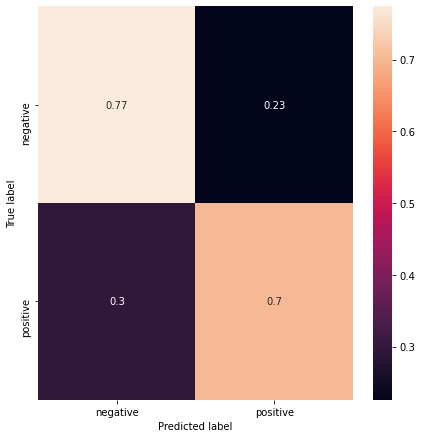

In [532]:
# predict over validation to assess model
y_pred = np.argmax(model.predict(x_val_pad), axis=-1)

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

print('Train accuracy :' + str(acc[-1]))
print('Val accuracy :' + str(val_acc[-1]))

plot_confussion_matrix(labels = y_val_seq, predictions = y_pred, classes = label_index.keys(), figsize = 6)